In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import interp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import re

### Data dictionary

- **survival**	Survival	0 = No, 1 = Yes
- **pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- **sex**	Sex	
- **Age**	Age in years	
- **sibsp**	# of siblings / spouses aboard the Titanic	
- **parch**	# of parents / children aboard the Titanic	
- **ticket**	Ticket number	
- **fare**	Passenger fare	
- **cabin**	Cabin number	
- **embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S =  Southampton

In [338]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [339]:
passenger_id = test['PassengerId']

In [340]:
full_data = [train, test]

### Explore several categorical features via visualization

In [341]:
def plot_proportion(feature, data):
    survived = data[data['Survived'] == 1][feature].value_counts()
    dead = data[data['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind = 'bar', stacked = True, figsize = (10, 5))

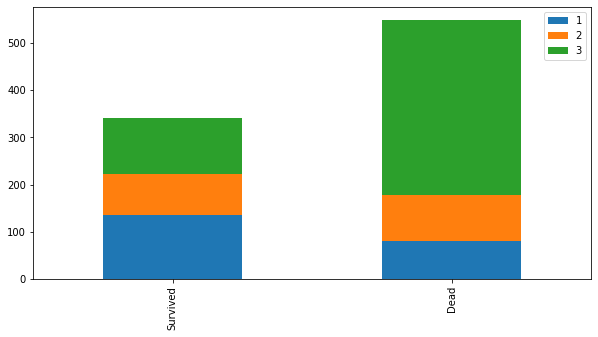

In [342]:
plot_proportion('Pclass', train)

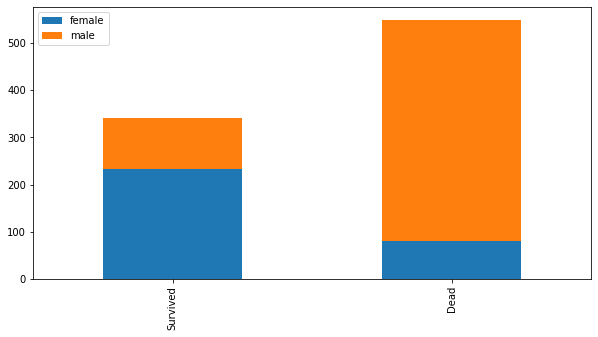

In [343]:
plot_proportion('Sex', train)

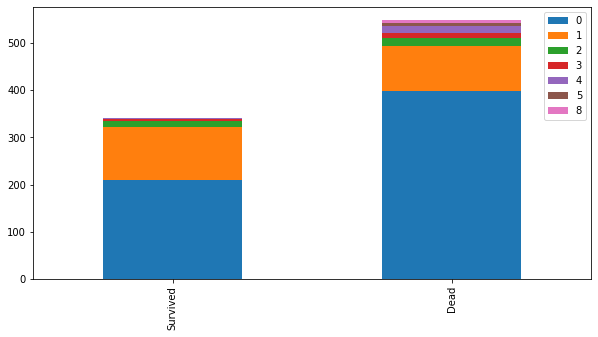

In [344]:
plot_proportion('SibSp', train)

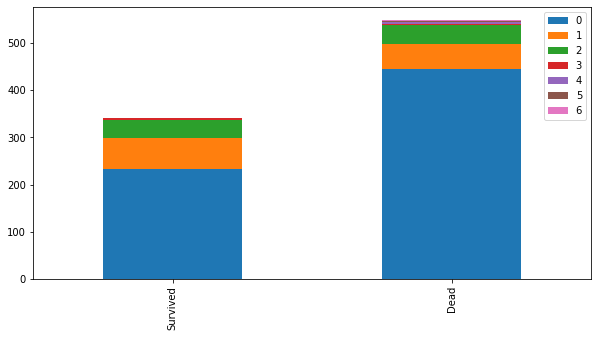

In [345]:
plot_proportion('Parch', train)

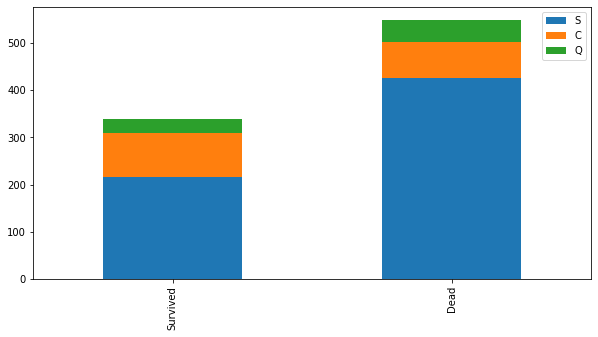

In [346]:
plot_proportion('Embarked', train)

### Clean and preprocess features

In [347]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [348]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    else:
        return ""

In [349]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
        
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    dataset['Title'] = dataset['Name'].apply(get_title)
    
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    dataset['Title'] = dataset['Title'].map({"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5})
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] 

In [350]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

### Use grid search with cross validation to find the best performing model

In [351]:
y_train_full = train['Survived']

In [352]:
X_train_full = train.drop(['Survived'], axis = 1)

In [353]:
passenger_ids = passenger_id.to_frame()

In [354]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=42)

### Define functions for gridsearch and cross validation 

For the task of binary classification, we will procede with three models - Random Forest, Logistic Regression and Linear SVM.

We will define a number of functions that will help train the model and evaluate its performance.

In [355]:
def grid_search_cross_validation(learner, params, scoring, X_train, y_train):
    clf = GridSearchCV(estimator=learner, param_grid=params, scoring=scoring)
    clf.fit(X_train, y_train)
    return clf.best_params_, clf.best_score_, clf.best_estimator_

def perform_grid_search(learners_with_params):
    learners_with_best_params = {}
    for name, learner_with_params in learners_with_params.items():
        learner = learner_with_params[0]
        params = learner_with_params[1]
        scoring = 'f1'
        print("Tuning hyper-parameters for learner '%s' from the range %s..." % (name, params))
        best_params, best_score, best_estimator = grid_search_cross_validation(learner, params, scoring, X_train, y_train)
        print("Best parameters = %s, best score = %s." % (best_params, best_score))
        learners_with_best_params[name] = (best_params, best_score, best_estimator)
        print()
    return learners_with_best_params

def get_roc_binary_classification(y_train, y_scores):
    fpr, tpr, thresholds = roc_curve(y_train, y_scores[:,1])
    return fpr, tpr 

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for %s' % best_classifier[0])
    
def get_auc(y_train, y_scores_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_scores_prob[:,1])
    print('AUC for %s is %f' % (best_classifier[0], metrics.auc(fpr, tpr)))

In [356]:
learners_with_params = {
    'Random Forest': (
        RandomForestClassifier(random_state=0),
        [{'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 7, 10], 'bootstrap': [False, True]}]
    ),
    'Logistic Regression': (
        LogisticRegression(random_state=0),
        [{'solver': ['lbfgs', 'newton-cg', 'saga']}]
    ),
    'Linear SVM': (
        LinearSVC(random_state=0),
        [{'tol': [0.0001], 'C': [1.0]}]), 
        
    'XGboost' : (
        XGBClassifier(random_state=0, booster = 'gbtree' ),
        [{'eta': [0.1, 0.2, 0.3], 'gamma': [0, 10, 100], 'max_depth': [5, 6, 10]}]
    )
}

In [ ]:
learners_with_best_params = perform_grid_search(learners_with_params)

In [358]:
for learner_name, params_score_learner in learners_with_best_params.items():
    print(learner_name)
    print(params_score_learner[0])
    print(params_score_learner[1])
    print()

Random Forest
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 5}
0.7373169601482854

Logistic Regression
{'solver': 'lbfgs'}
0.7113239970329447

Linear SVM
{'C': 1.0, 'tol': 0.0001}
0.6972816492184808

XGboost
{'eta': 0.1, 'gamma': 0, 'max_depth': 10}
0.7246376424564234



In [359]:
best_classifier = sorted(learners_with_best_params.items(), key=lambda x: x[1][1], reverse=True)[0]

In [360]:
best_classifier_name, classifier_on_best_params = best_classifier[0], best_classifier[1][2]

In [361]:
classifier_on_best_params.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [362]:
y_predicted_proba = classifier_on_best_params.predict_proba(X_val)

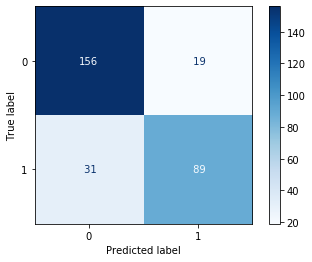

In [363]:
plot_confusion_matrix(classifier_on_best_params, X_val, y_val, cmap=plt.cm.Blues,values_format = '3g')

In [364]:
fpr, tpr = get_roc_binary_classification(y_val, y_predicted_proba)

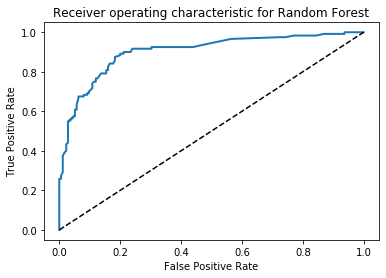

In [365]:
plot_roc_curve(fpr, tpr)

In [366]:
get_auc(y_val, y_predicted_proba)

AUC for Random Forest is 0.901714


In [367]:
y_predicted = classifier_on_best_params.predict(X_val)

In [368]:
f1_score(np.array(y_val), y_predicted)

0.780701754385965

### Creating a submission

In [369]:
predictions = classifier_on_best_params.predict(test)

In [370]:
def make_submission(predictions, learner_name):
    survived = pd.DataFrame(data={'Survived': predictions})
    results = pd.merge(passenger_ids, survived, left_index=True, right_index=True)
    results.to_csv(path_or_buf = 'titanic_results_%s.csv' % learner_name, header = True, index = False)     

In [371]:
make_submission(predictions, '%s' % best_classifier_name)